## The Effects of Lifestyle Based Variables on the Math Grades of Students
### Introduction:
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and describe the dataset that was used to answer the question
### Methods & Results:
describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
loads data from the original source on the web 
wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend
### Discussion:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?
### References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.


### Introduction

This group will be examining factors influencing student performance in Portuguese secondary students to attempt to answer the question of which factor is most influential in promoting good grades. We will be approaching this problem using classification techniques in R. The student achievement data was collected from 2 Portuguese secondary schools and assessed performance in mathematics. The data includes the target variable (student grades during periods 1, 2, and 3) in addition to 30 predictor variables. For the purposes of this project, we have chosen 3 variables with numerical values to be able to determine the answer to our question. The 3 variables are hours of free time, hours of study time, and number of school absences. Moreover, the data originally comes in an excel sheet format which will need to be considered when reading the data set into R. The data can be accessed through the link below Data set: https://archive.ics.uci.edu/dataset/320/student+performance Data set source: UC Irvine Machine Learning Repository

### Reading in the Data

Here, we read in the data from our GitHub repository. The original dataset is from the UC Irvine Machine Learning Repository, but for reproducibility, we will read it in from a GitHub URL. This is what we have done below, using `read_csv2` to read in the data, as it uses a semi-colon as a delimiter. We use `head` to display the first 6 lines of our dataset.

In [7]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1)

In [8]:
url <- "https://raw.githubusercontent.com/chloezandberg/dsci-100-project/main/student-mat.csv"
math_data <- read_csv2(url)
head(math_data)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,10,15,15,15


### Wrangling the Data

Below, we clean the data by selecting only the predictor variables that we will use in our classification problem, `freetime`, `studytime`, and `absences`, and the variable we intend to predict, `G3`. For context, G3 is the final grade in the Portuguese school system. Next, we calculate `G3` as a percentage (as G3 is reported out of 20 in the Portuguese school system). Finally, we recoded the final grade percentages according to the UBC grading scheme to be letter grades for our classification problem. We use `head` to display the first six rows of our clean data. See the first 6 rows of our clean data, Table 1, below.

In [9]:
clean_math_data <- math_data |>
    select(freetime, studytime, absences, G3) |> # G3 is final grade in Portugese school system
    mutate(final_percentage = (G3/20)*100) |> # final grade is out of 20
    mutate(letter_grade = cut(final_percentage, c(-1, 49, 54, 67, 79, 100))) |> # recoding to be letter grade levels for classification problem
    mutate(letter_grade = recode(letter_grade,                                  # had to set lower limit to -1 to include grades of 0%
                                           "(-1,49]" = "F",
                                           "(49,54]" = "D",
                                           "(54,67]" = "C",
                                           "(67,79]" = "B",
                                           "(79,100]" = "A")) |> 
    select(freetime, studytime, absences, letter_grade) |>
    drop_na()
                                           
head(clean_math_data)
print('Table 1: First 6 rows of clean dataset')

freetime,studytime,absences,letter_grade
<dbl>,<dbl>,<dbl>,<fct>
3,2,6,F
3,2,4,F
3,2,10,D
2,3,2,B
3,2,4,D
4,2,10,B


[1] "Table 1: First 6 rows of clean dataset"


### Exploratory Data Analysis

Below, we explore our clean dataset by counting up how many students received each letter grade. We do this by grouping our dataset by letter grade (`letter_grade`), using `group_by`. Then, we use `summarize` to count the number of rows (or observations) of each letter grade to get their respective counts (see Table 2 below). We also explore our data by finding the average of each predictor variable using `map_df`, and renaming each column to reflect this. Finally, we count up the total number of observations in our dataset and report this with the average of each predictor (see Table 3 below).

In [10]:
avg_predictors <- clean_math_data |>
            select(freetime, studytime, absences) |>
            map_df(mean) |>
            rename("avg_freetime" = "freetime", # renaming each column to reflect that each column is now the average of each predictor variable
                   'avg_studytime' = 'studytime',
                   'avg_absences' = 'absences')

count_observations <- nrow(clean_math_data) # counting number of observations in the dataset

count_class <- clean_math_data |>
            group_by(letter_grade) |>
            summarize(count = n()) # counting how many instances occur of each letter grade, grouped by letter_grade

count_class
print('Table 2: Count of each letter grade (A, B, C, D, or F)')

observations_tibble <- tibble(number_observations = count_observations)

exploratory_data_analysis <- bind_cols(observations_tibble, avg_predictors) # binding the total number of observations with the average of each predictor

exploratory_data_analysis
print('Table 3: Total number of observations and the means of each predictor variable')

letter_grade,count
<fct>,<int>
F,130
D,56
C,109
B,60
A,40


[1] "Table 2: Count of each letter grade (A, B, C, D, or F)"


number_observations,avg_freetime,avg_studytime,avg_absences
<int>,<dbl>,<dbl>,<dbl>
395,3.235443,2.035443,5.708861


[1] "Table 3: Total number of observations and the means of each predictor variable"


### Visualizing the Data

Below, we create several visualizations to get a sense of what our data looks like prior to our analysis. First, we create `math_plot` which is a bar chart that helps us investigate which of the final grades are most common of the 5 (A, B, C, D, and F). Next, we create `absences_dist` which is a bar chart that helps us investigate what the distribution of absences look like for students. After this, we create `freetime_dist` which plots the distribution of each level of free time a student has (on a scale from 1-4). Finally, we create `studytime_dist` which plots the distribution of the amount of study time each student has.

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


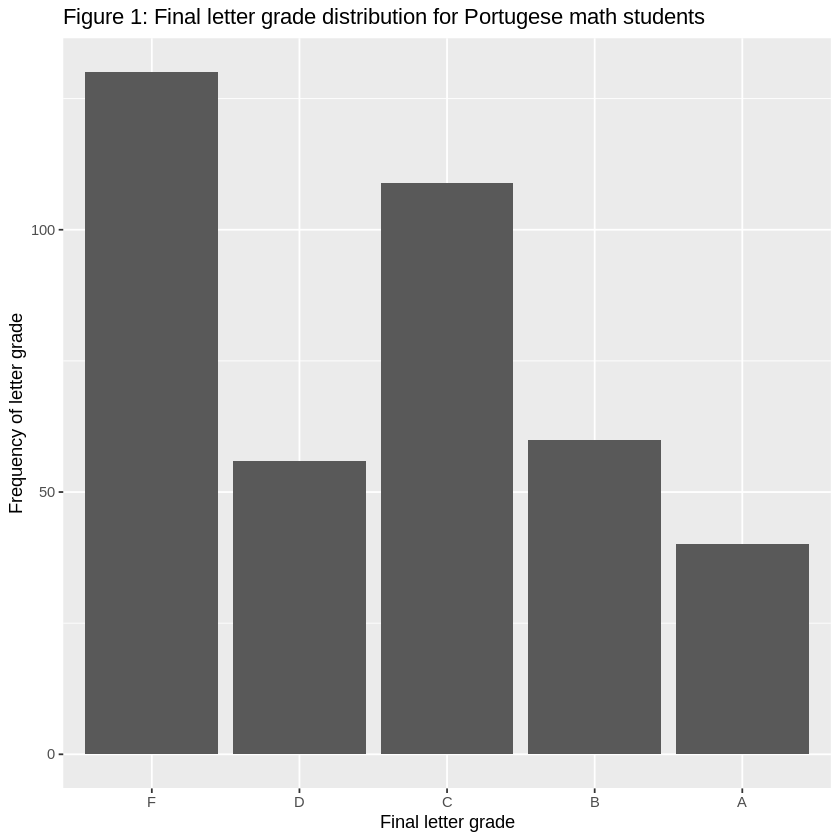

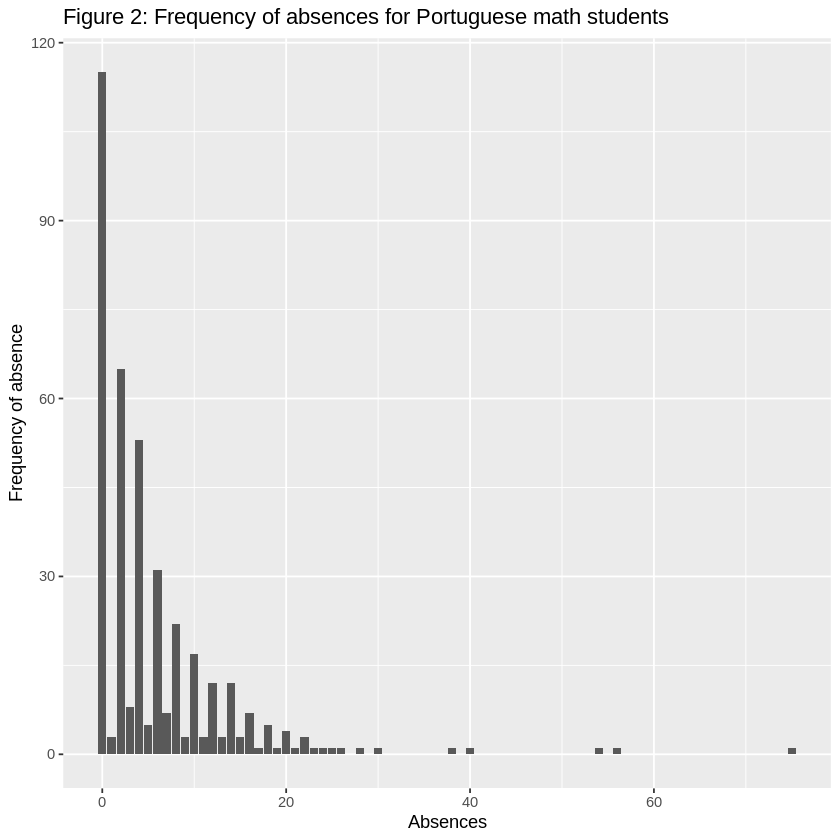

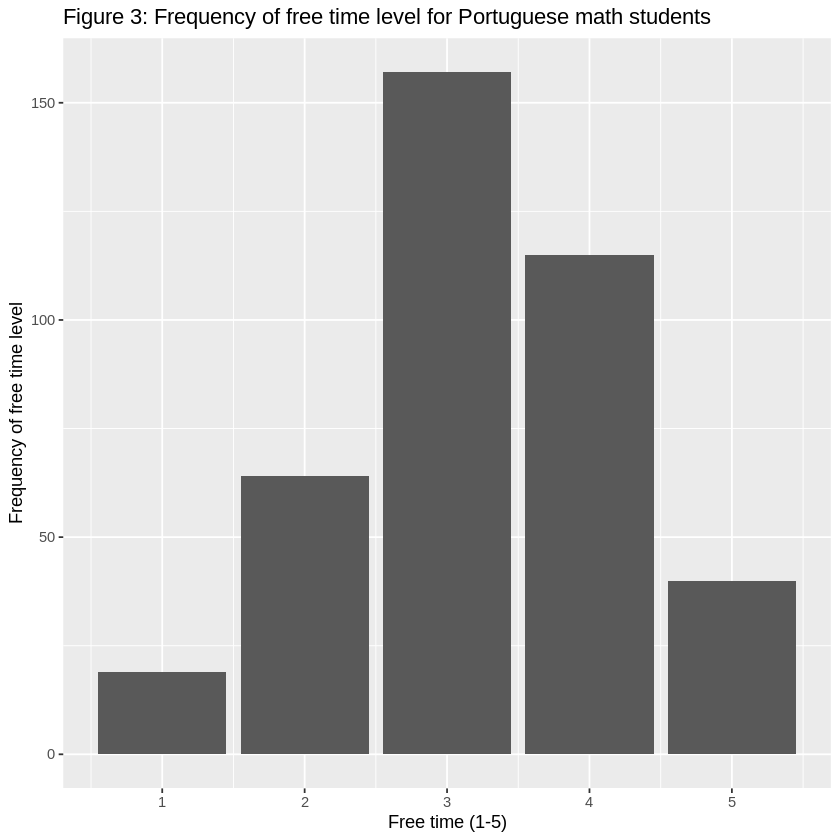

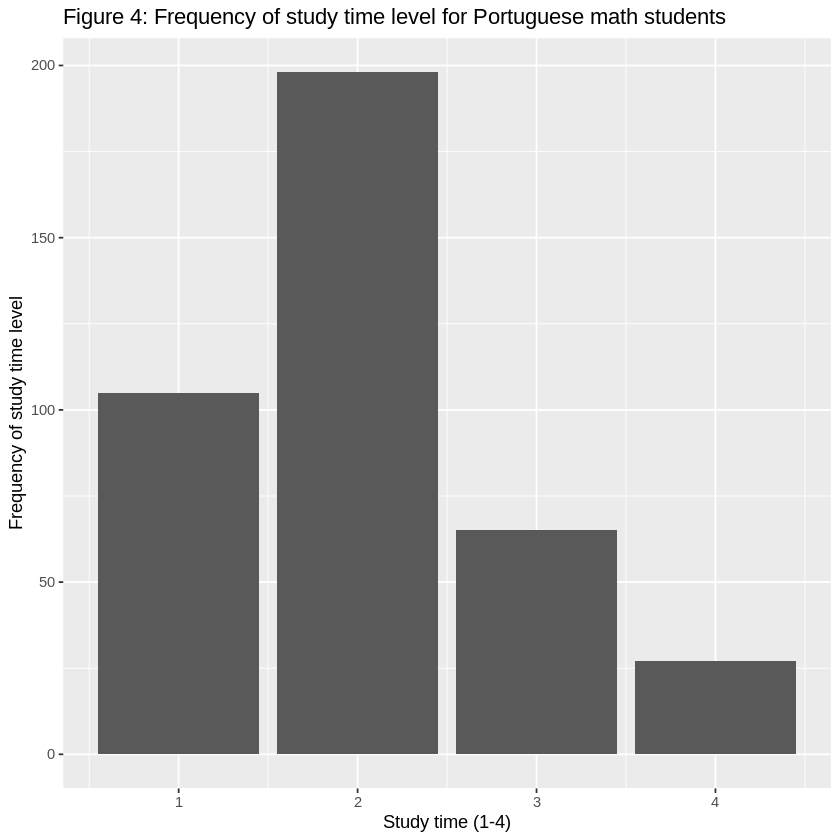

In [11]:
math_plot <- ggplot(clean_math_data, aes(x=letter_grade)) +
                geom_histogram(stat='count') +
                labs(x="Final letter grade",
                y="Frequency of letter grade") +
                ggtitle("Figure 1: Final letter grade distribution for Portugese math students") # investigate which grades are most common

absences_dist <- ggplot(clean_math_data, aes(x=absences)) + #  number of school absences (numeric: from 0 to 93)
                    geom_histogram(stat='count') +
                    labs(x='Absences',
                         y='Frequency of absence') +
                        ggtitle('Figure 2: Frequency of absences for Portuguese math students')

freetime_dist <- ggplot(clean_math_data, aes(x=freetime)) + # free time after school (numeric: from 1 - very low to 5 - very high)
                    geom_bar(stat='count') +
                    labs(x='Free time (1-5)',
                         y='Frequency of free time level') +
                        ggtitle('Figure 3: Frequency of free time level for Portuguese math students')

studytime_dist <- ggplot(clean_math_data, aes(x=studytime)) + # weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
                    geom_bar(stat='count') +
                    labs(x='Study time (1-4)',
                         y='Frequency of study time level') +
                        ggtitle('Figure 4: Frequency of study time level for Portuguese math students')

math_plot
absences_dist
freetime_dist
studytime_dist

These are two visualizations that provide initial insight into the relationships between absences, studytime, freetime, and the letter grades generally associated with them. Before even using the classification model, it can be helpful to see what it is using as its basis for information, so that is what these graphs are for. Figure 5 shows the relationships between absences and freetime, and figure 6 represents the amount of study time to absences. 

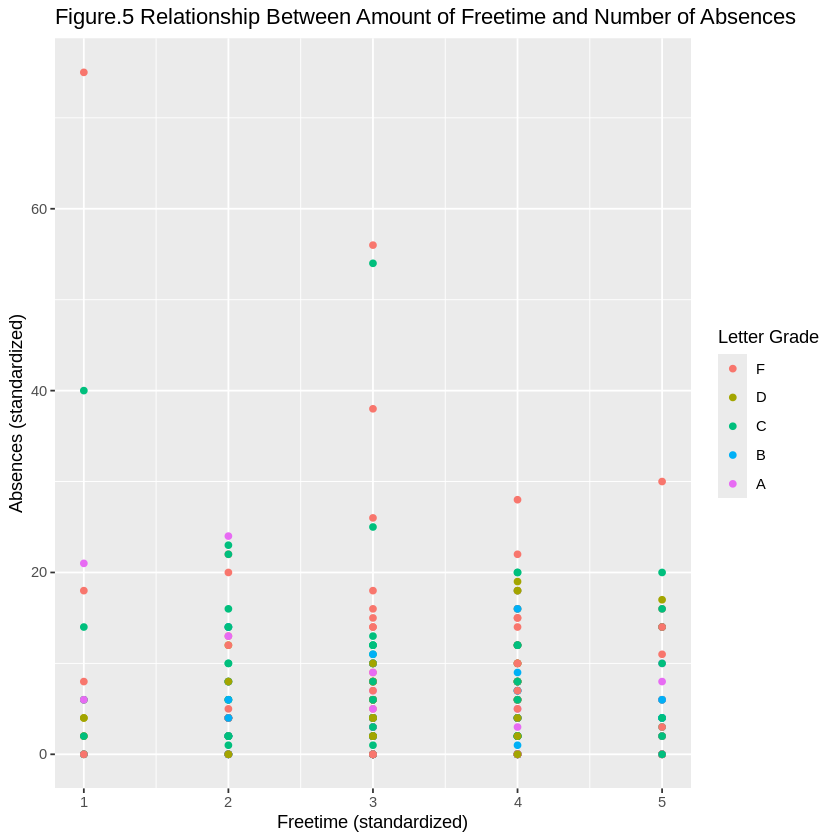

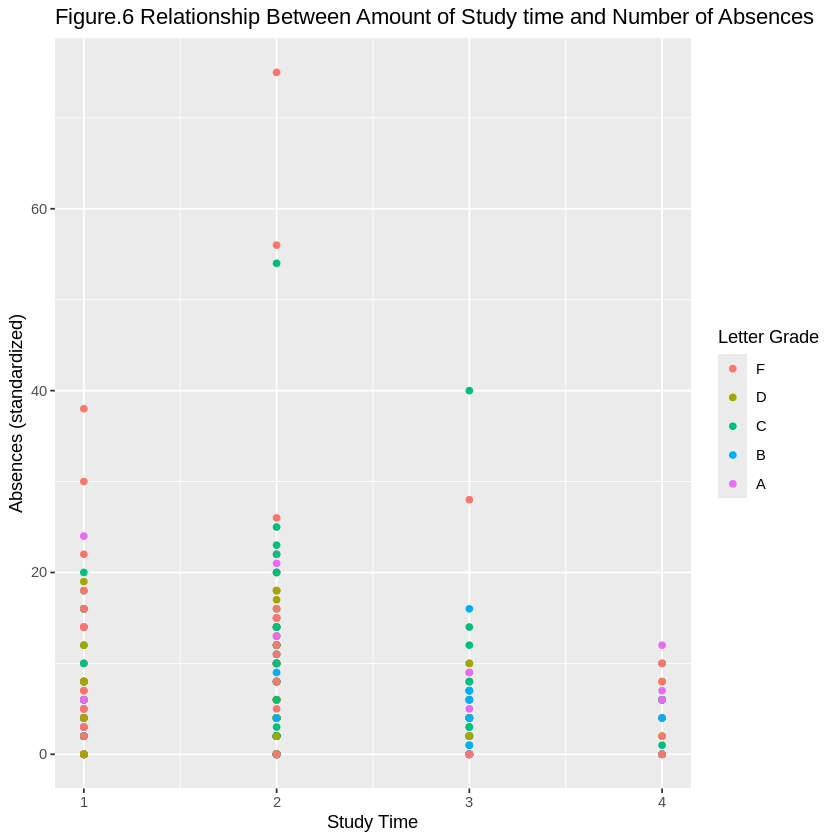

In [12]:
clean_math_plot<-ggplot(clean_math_data, aes(x= freetime, y=absences, colour = letter_grade))+
geom_point()+
labs(x = "Freetime (standardized)", y = "Absences (standardized)", color = "Letter Grade")+
ggtitle("Figure.5 Relationship Between Amount of Freetime and Number of Absences")
clean_math_plot

clean_math_plot2<-ggplot(clean_math_data, aes(x= studytime, y=absences, colour = letter_grade))+
geom_point()+
labs(x = "Study Time", y = "Absences (standardized)", color = "Letter Grade")+
ggtitle("Figure.6 Relationship Between Amount of Study time and Number of Absences")
clean_math_plot2

### K-NN Classification Analysis

To perform our analysis, we will use the K-NN Classification algorithm, choosing our K-nearest neighbours based on which one maximizes accuracy. We choose to maximize accuracy, as it doesn't make sense to focus on recall or precision as there isn't one particular letter grade that we are particularly interested in. We will achieve this by splitting our data into a testing and training set, and performing multiple iterations of the K-nearest neighbours classification algorithm with K ranging from 1-10. Out of these 10 neighbours, we will choose the one maximizing accuracy, and take this to be our optimal K. This is to create the model we will use to predict the letter grades based on the `freetime`, `studytime` and `absence` information provided.

In [13]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_fit <- knn_spec |> 
       fit(letter_grade ~ absences + studytime + freetime, data = clean_math_data)


This is a test for the prediction model that was just created. It says that a student with a 3/4 study ranking, and a 5/5 free time score, with 0 absences most likely has an "A" letter grade.


In [14]:
new_obs <- tibble(studytime = 3, absences = 0, freetime = 5
                 )
letter_prediction <- predict(knn_fit, new_obs)

letter_prediction

.pred_class
<fct>
A


## Splitting the data into a training and test set

We will split the clean_math_data into a training set (75%) and a testing set (25%). Once the test set is created, we will put it in a lock box and not use it again until we have optimized the k-nn classifier using the training set. The variable letter_grade will serve as our class label.

To create the training and test set, first we use the initial_split function to split clean_math_data. We want to use 75% of the data. For the strata argument, place the variable we want to classify, letter_grade. Name the object we create math_split. Next, pass the math_split object to the training and testing functions and name respective objects math_train and math_test.

In [15]:
set.seed(2020)
math_split <- initial_split(clean_math_data, prop = 0.75, strata = letter_grade)  
math_train <- training(math_split)   
math_test <- testing(math_split)

math_train
math_test

freetime,studytime,absences,letter_grade
<dbl>,<dbl>,<dbl>,<fct>
2,2,0,A
5,3,0,A
5,2,2,A
⋮,⋮,⋮,⋮
5,2,11,F
5,1,3,F
2,1,5,F


freetime,studytime,absences,letter_grade
<dbl>,<dbl>,<dbl>,<fct>
3,2,4,D
5,1,16,F
2,1,4,B
⋮,⋮,⋮,⋮
1,2,0,B
4,2,2,D
4,3,0,F


The k-nearest neighbors is sensitive to the scale of the predictors, necessitating preprocessing to standardize them. It's crucial to use only the training data to define the preprocessing steps in our recipe, ensuring that the test data does not influence the model training in any way. After establishing the standardization preprocessor, it can then be applied to both the training and test data sets separately.

To scale and center the data, begin by inputting the vector of predictors into the recipe function. For scaling the predictors, use the `step_scale(all_predictors())` function. To center the predictors, use the `step_center(all_predictors())` function.

In [16]:
set.seed(2020)

math_recipe <- recipe(letter_grade ~ absences + studytime + freetime, data = clean_math_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
math_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



We've successfully split our data into training and testing sets and have preprocessed the data. Now, using the tidymodels package, we will build our K-nearest neighbors classifier exclusively with the training set. To start, define the classifier by setting K=3 neighbors and opting for the straight-line distance method.

In [17]:
set.seed(2020)

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
              set_engine("kknn") |>
              set_mode("classification")

Next, train the classifier with the training data set using the workflow function.

In [18]:
math_fit <- workflow() |>
       add_recipe(math_recipe) |>
       add_model(knn_spec_2) |>
       fit(data = math_train)
math_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5966102
Best kernel: rectangular
Best k: 5

Now that our K-nearest neighbor classifier object is ready, we can proceed with predicting the class labels for our test set.

In [19]:
set.seed(2020) 

math_test_predictions <- predict(math_fit, math_test) |>
    bind_cols(math_test)
math_test_predictions

.pred_class,freetime,studytime,absences,letter_grade
<fct>,<dbl>,<dbl>,<dbl>,<fct>
D,3,2,4,D
F,5,1,16,F
F,2,1,4,B
⋮,⋮,⋮,⋮,⋮
F,1,2,0,B
B,4,2,2,D
F,4,3,0,F


Next, we will evaluate initial model performance by using the metrics() function to calculate how well our model is performing with its current settings. 

In [20]:
initial_metrics <- metrics(math_test_predictions, truth = letter_grade, estimate = .pred_class)
initial_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.24000000
kap,multiclass,0.02476582


Now we examine the prediction errors. A confusion matrix is a useful tool for understanding the types of errors our model is making. It shows the counts of true positives, true negatives, false positives, and false negatives.

In [21]:
math_mat <- conf_mat(math_test_predictions, truth = letter_grade, estimate = .pred_class)
math_mat

          Truth
Prediction  F  D  C  B  A
         F  9  3  9  5  4
         D  5  2  4  1  0
         C  5  1  7  2  3
         B 12  6  6  4  1
         A  2  2  2  3  2

In [ ]:
Here, vfolding is performed to create a more robust analysis of the performance of the model. 

In [22]:
math_vfold <- vfold_cv(math_train, v = 5, strata = letter_grade)


In [23]:
math_resample_fit <- workflow() |>
      add_recipe(math_recipe) |>
      add_model(knn_spec) |>
      fit_resamples(resamples = math_vfold)


In [24]:
math_metrics<-collect_metrics(math_resample_fit)
math_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.2745280,5,0.01789671,Preprocessor1_Model1
roc_auc,hand_till,0.5555371,5,0.01685922,Preprocessor1_Model1


In [56]:
knn_tune<-nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
set_engine("kknn")|>
set_mode("classification")
knn_tune

knn_results <- workflow() |>
      add_recipe(math_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = math_vfold, grid = 14) |>
      collect_metrics()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


This graph represents the accuracy of the model's predictions as the number of neighbours increases. Given that it seems to plateau in accuracy at around 10 neighbours with an accuracy of ~0.35%, we will use K = 10 in our analysis. One reason that the accuracy could be so low is that there was a high number of outliers in the testing group, or that our variables are not extremely correlational. Regardless, we will be examining them in order to predict outcomes. 

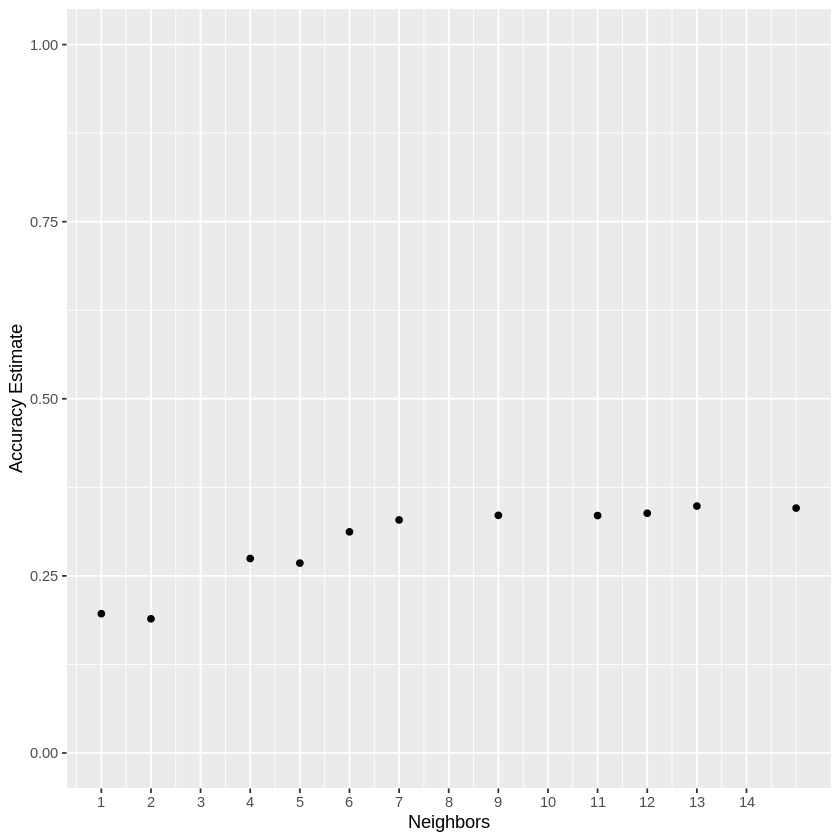

In [57]:
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [58]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_fit <- knn_spec |> 
       fit(letter_grade ~ absences + studytime + freetime, data = clean_math_data)
